# Process and Plot the Relationship Between BA Temperature and Interconnection Load Extremes

This notebook analyzes the relationship between Balancing Authority (BA) temperature extremes and interconnection load extremes.

In [1]:
# Start by importing the packages we need:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from glob import glob


## Set the Directory Structure

In [5]:
# Identify the data input and output directories:
weather_data_input_dir =  '/Users/burl878/Documents/IMMM/Data/TELL/Production_Runs/tell_data/wrf_to_tell_data/historic/'
load_data_input_dir =  '/Users/burl878/Documents/IMMM/Data/TELL/Production_Runs_Old/tell_data/outputs/postprocessed/interconnection_load_time_series/'
metadata_input_dir =  '/Users/burl878/Documents/IMMM/Data/TELL/Analysis/'
data_output_dir =  '/Users/burl878/Documents/IMMM/Data/TELL/Production_Runs_Old/tell_data/outputs/postprocessed/ba_temperature_to_interconnection_load_extremes/'
image_output_dir =  '/Users/burl878/Documents/IMMM/Images/TELL/Analysis/BA_Temperature_to_Interconnection_Load_Extremes/'


## Process the Historical Relationship Data

In [6]:
# Define a function to process the time series of BA temperature and interconnection load:
def process_extreme_relationships(weather_data_input_dir: str, load_data_input_dir: str, data_output_dir: str, ba_to_process: str, interconnection: str):
    # Read in the historical interconnection loads file:
    ics_df = pd.read_csv(load_data_input_dir + 'historic.csv')
    
    # Subset to just the data for the interconnection being processed:
    ics_df = ics_df.loc[ics_df['Interconnection'] == interconnection]
    
    # Rename some variables for simplicity:
    ics_df.rename(columns={'Interconnection_Load_MWh': 'Load_MWh', 'Percentile': 'Load_Percentile'}, inplace=True)
    
    # Loop over the years from the 1980 to 2019:
    for year in range(1980,2020,1):
        # Read in the historical meteorology.csv file:
        met_df = pd.read_csv((weather_data_input_dir + ba_to_process + '_WRF_Hourly_Mean_Meteorology_' + str(year) + '.csv'))
        
        # Set the time value as a datetime variable:
        met_df['Datetime'] = pd.to_datetime(met_df['Time_UTC'])
        
        # Add a column with the month values to be used in grouping:
        met_df['Month'] = met_df['Datetime'].dt.strftime('%m').astype(str).astype(int)
        
        # Convert the temperature from Kelvin to Fahrenheit:
        met_df['T2_F'] = ((1.8 * (met_df['T2'] - 273)) + 32).round(2)
        
        # Compute the annual percentile for each hourly temperature value:
        met_df['T2_Percentile'] = met_df['T2_F'].rank(pct=True).round(3)
        
        # Merge the met_df and ics_df dataframes based on common time values:
        merged_df = met_df.merge(ics_df, on=['Time_UTC'])
        
        # Subset to just the variables we need:
        merged_df = merged_df[['Time_UTC', 'Month', 'T2_F', 'T2_Percentile', 'Load_MWh', 'Load_Percentile']].copy()
        
        # Aggregate the output into a new dataframe:
        if year == 1980:
           output_df = merged_df
        else:
           output_df = pd.concat([output_df , merged_df])
    
    # Subset the output_df to just the summer and winter months:
    winter_df = output_df.loc[(output_df['Month'] == 1) | (output_df['Month'] == 2) | (output_df['Month'] == 3) | (output_df['Month'] == 10) | (output_df['Month'] == 11) | (output_df['Month'] == 12)]
    summer_df = output_df.loc[(output_df['Month'] == 4) | (output_df['Month'] == 5) | (output_df['Month'] == 6) | (output_df['Month'] == 7) | (output_df['Month'] == 8) | (output_df['Month'] == 9)]

    # Compute the correlations between the BA T2 percentile and the interconnection load percentile:
    all_corr = output_df['T2_Percentile'].corr(output_df['Load_Percentile']).round(2)
    winter_corr = winter_df['T2_Percentile'].loc[(winter_df['T2_Percentile'] <= 0.5)].corr(winter_df['Load_Percentile'].loc[(winter_df['T2_Percentile'] <= 0.5)]).round(2)
    summer_corr = summer_df['T2_Percentile'].loc[(summer_df['T2_Percentile'] >= 0.5)].corr(summer_df['Load_Percentile'].loc[(summer_df['T2_Percentile'] >= 0.5)]).round(2)

    #Initiate a counter and empty dataframe to store the results:
    counter = 0;
    stats_df = pd.DataFrame()

    # Loop over the range of T2 percentile values:
    for bin in np.arange(0,1,0.02):
        # Iterate the counter by one:
        counter = counter + 1 
    
        # Put the statistics in a new dataframe:
        stats_df.loc[counter, 'BA'] = ba_to_process
        stats_df.loc[counter, 'Bin'] = ((bin+(bin+0.02)) / 2)
        stats_df.loc[counter, 'All_Corr'] = all_corr
        stats_df.loc[counter, 'Winter_Corr'] = winter_corr
        stats_df.loc[counter, 'Summer_Corr'] = summer_corr
        
        # Subset the data to just the T2 values in a given bin and compute the corresponding mean load percentile:
        all_subset_df = output_df.loc[(output_df['T2_Percentile'] >= bin) & (output_df['T2_Percentile'] < (bin+0.02))]
        if all_subset_df.empty == False:
           stats_df.loc[counter, 'All_Mean'] = all_subset_df['Load_Percentile'].mean().round(2)
        else:
           stats_df.loc[counter, 'All_Mean'] = np.nan
        del all_subset_df
    
        # Do the same except for the winter subset:
        winter_subset_df = winter_df.loc[(winter_df['T2_Percentile'] >= bin) & (winter_df['T2_Percentile'] < (bin+0.02))]
        if winter_subset_df.empty == False:
           stats_df.loc[counter, 'Winter_Mean'] = winter_subset_df['Load_Percentile'].mean().round(2)
        else:
           stats_df.loc[counter, 'Winter_Mean'] = np.nan
        del winter_subset_df
    
        # Do the same except for the summer subset:
        summer_subset_df = summer_df.loc[(summer_df['T2_Percentile'] >= bin) & (summer_df['T2_Percentile'] < (bin+0.02))]
        if summer_subset_df.empty == False:
           stats_df.loc[counter, 'Summer_Mean'] = summer_subset_df['Load_Percentile'].mean().round(2)
        else:
           stats_df.loc[counter, 'Summer_Mean'] = np.nan
        del summer_subset_df

    # Write out the time series dataframe to a .csv file:
    output_df.to_csv((os.path.join(data_output_dir + ba_to_process + '_BA_Temperature_to_Interconnection_Load_Extremes.csv')), sep=',', index=False)
    stats_df.to_csv((os.path.join(data_output_dir + ba_to_process + '_BA_Temperature_to_Interconnection_Load_Extremes_Statistics.csv')), sep=',', index=False)
    
    return output_df, stats_df


In [7]:
output_df, stats_df = process_extreme_relationships(weather_data_input_dir = weather_data_input_dir,
                                                    load_data_input_dir = load_data_input_dir, 
                                                    data_output_dir = data_output_dir, 
                                                    ba_to_process = 'WAUW',
                                                    interconnection = 'WECC')

stats_df


,BA,Bin,All_Corr,Winter_Corr,Summer_Corr,All_Mean,Winter_Mean,Summer_Mean
1,WAUW,0.01,0.32,-0.25,0.68,0.61,0.61,0.14
2,WAUW,0.03,0.32,-0.25,0.68,0.57,0.57,0.17
3,WAUW,0.05,0.32,-0.25,0.68,0.55,0.55,0.26
4,WAUW,0.07,0.32,-0.25,0.68,0.53,0.53,0.33
5,WAUW,0.09,0.32,-0.25,0.68,0.51,0.51,0.26
6,WAUW,0.11,0.32,-0.25,0.68,0.50,0.51,0.26
7,WAUW,0.13,0.32,-0.25,0.68,0.49,0.49,0.23
8,WAUW,0.15,0.32,-0.25,0.68,0.47,0.48,0.24
9,WAUW,0.17,0.32,-0.25,0.68,0.46,0.47,0.21
10,WAUW,0.19,0.32,-0.25,0.68,0.45,0.46,0.26


In [ ]:
# Define a function to plot the relationship between BA temperature and interconnection load extremes:
def plot_extreme_relationships(ba_to_plot: str, interconnection: str, data_output_dir: str, image_output_dir: str, image_resolution: int, save_images=False):
    
    # Check to see if the output already exist and if not then process it:
    if os.path.isfile((os.path.join(data_output_dir + ba_to_plot + '_BA_Temperature_to_Interconnection_Load_Extremes.csv'))) == True:
       # Load in the pre-processed data:
       output_df = pd.read_csv((os.path.join(data_output_dir + ba_to_plot + '_BA_Temperature_to_Interconnection_Load_Extremes.csv')))
       stats_df = pd.read_csv((os.path.join(data_output_dir + ba_to_plot + '_BA_Temperature_to_Interconnection_Load_Extremes_Statistics.csv')))
    else:
       output_df, stats_df = process_extreme_relationships(weather_data_input_dir = weather_data_input_dir,
                                                           load_data_input_dir = load_data_input_dir, 
                                                           data_output_dir = data_output_dir, 
                                                           ba_to_process = ba_to_plot,
                                                           interconnection = interconnection)
    
    # Subset the output_df to just the summer and winter months:
    winter_df = output_df.loc[(output_df['Month'] == 1) | (output_df['Month'] == 2) | (output_df['Month'] == 3) | (output_df['Month'] == 10) | (output_df['Month'] == 11) | (output_df['Month'] == 12)]
    summer_df = output_df.loc[(output_df['Month'] == 4) | (output_df['Month'] == 5) | (output_df['Month'] == 6) | (output_df['Month'] == 7) | (output_df['Month'] == 8) | (output_df['Month'] == 9)]

    # Randomly subsample the dataframes:
    output_df_sample = output_df.sample(frac=0.10, replace=False, random_state=1)
    winter_df_sample = winter_df.sample(frac=0.10, replace=False, random_state=1)
    summer_df_sample = summer_df.sample(frac=0.10, replace=False, random_state=1)
    
    # Make the plot:
    plt.figure(figsize=(25, 10))
    plt.rcParams['font.size'] = 12
    
    # Plot the results using all of the data:
    plt.subplot(211)
    plt.scatter(output_df_sample['T2_Percentile'], output_df_sample['Load_Percentile'], s=5, c='gray', label='Individual Hour')
    plt.plot(stats_df['Bin'], stats_df['All_Mean'], 'k', linewidth=3, label=('Mean: Correlation = ' + stats_df['All_Corr'].mean().round(2).astype(str)))
    plt.legend(loc='upper left'); plt.xlim([0, 1]); plt.ylim([0, 1])
    plt.grid(True)
    plt.xlabel(('2-m Air Temperature Percentile in ' + ba_to_plot));
    plt.ylabel(('Total Load Percentile in the ' + interconnection))
    plt.title(('All Data (1980-2019): ' + ba_to_plot + ' Temperatures vs. ' + interconnection + ' Total Loads'))
    
    # Plot the results using only the summer data:
    plt.subplot(223)
    plt.scatter(summer_df_sample['T2_Percentile'], summer_df_sample['Load_Percentile'], s=5, c='red', label='Individual Hour')
    plt.plot(stats_df['Bin'], stats_df['Summer_Mean'], 'k', linewidth=3, label=('Mean: Correlation = ' + stats_df['Summer_Corr'].mean().round(2).astype(str)))
    plt.legend(loc='upper left'); plt.xlim([0, 1]); plt.ylim([0, 1])
    plt.xlim([0.5, 1])
    plt.grid(True)
    plt.xlabel(('2-m Air Temperature Percentile in ' + ba_to_plot));
    plt.ylabel(('Total Load Percentile in the ' + interconnection))
    plt.title(('Only Summer Data'))
    
    # Plot the results using only the winter data:
    plt.subplot(224)
    plt.scatter(winter_df_sample['T2_Percentile'], winter_df_sample['Load_Percentile'], s=5, c='blue', label='Individual Hour')
    plt.plot(stats_df['Bin'], stats_df['Winter_Mean'], 'k', linewidth=3, label=('Mean: Correlation = ' + stats_df['Winter_Corr'].mean().round(2).astype(str)))
    plt.legend(loc='upper left'); plt.xlim([0, 1]); plt.ylim([0, 1])
    plt.xlim([0, 0.5])
    plt.grid(True)
    plt.xlabel(('2-m Air Temperature Percentile in ' + ba_to_plot));
    plt.ylabel(('Total Load Percentile in the ' + interconnection))
    plt.title(('Only Winter Data'))
    
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       filename = (ba_to_plot + '_Extremes_Relationships.png')
       plt.savefig(os.path.join(image_output_dir, filename), dpi=image_resolution, bbox_inches='tight', facecolor='white')


In [ ]:
plot_extreme_relationships(ba_to_plot = 'WAUW',
                           interconnection = 'WECC',
                           data_output_dir = data_output_dir,
                           image_output_dir = image_output_dir, 
                           image_resolution = 300, 
                           save_images = True)


In [24]:
# Define a function to plot the relationships across BAs in an interconnection:
def plot_ba_to_interconnection_relationships(interconnection: str, metadata_input_dir: str, data_output_dir: str, image_output_dir: str, image_resolution: int, save_images=False):
    # Read in the BA-to-Interconnection mapping file:
    ba_mapping = pd.read_csv(metadata_input_dir + 'BA_to_Interconnection_Mapping.csv')
    
    # Subset to just the interconnection being analyzed:
    ba_mapping = ba_mapping.loc[ba_mapping['Interconnection'] == interconnection]
    
    # Make a list of all of the BAs in "ba_mapping":
    bas = ba_mapping['BA_Code'].unique()
    
    #Initiate an empty dataframe to store the results:
    corr_df = pd.DataFrame()
    
    # Loop over the BAs and concatenate their statistics files:
    for i in range(len(bas)):
        # Read in the statistics for the BA being processed:
        stats_df = pd.read_csv((os.path.join(data_output_dir + bas[i] + '_BA_Temperature_to_Interconnection_Load_Extremes_Statistics.csv')))

        # Extract the correlation statistics:
        corr_df.loc[i, 'BA'] = bas[i]
        corr_df.loc[i, 'All_Corr'] = stats_df['All_Corr'].mean().round(2)
        corr_df.loc[i, 'Winter_Corr'] = stats_df['Winter_Corr'].mean().round(2)
        corr_df.loc[i, 'Summer_Corr'] = stats_df['Summer_Corr'].mean().round(2)
        
        # Aggregate the statistics into a new dataframe:
        if i == 0:
           agg_df = stats_df
        else:
           agg_df = pd.concat([agg_df, stats_df])
    
    agg_df = agg_df.sort_values(by='All_Corr', ascending=False, ignore_index=True)
    
    # agg_df = agg_df.loc[agg_df['BA'] == 'BANC']
    
    # Make the plot:
    plt.figure(figsize=(25, 10))
    plt.rcParams['font.size'] = 12
    result = agg_df.pivot(index=['Bin'], columns=['BA','All_Corr'], values=['All_Mean'])
    ax = sns.heatmap(result,
                     vmin=0,vmax=1,
                     # cmap='RdBu_r', 
                     cmap='PuOr',
                     yticklabels=['1%','','','','','','','','','','','','','','','','','','','','','','','','','50%','','','','','','','','','','','','','','','','','','','','','','','','99%'],
                     xticklabels=['BANC','SRP','TIDC','AZPS','CISO','WALC','TEPC','IID','LDWP','EPE','NEVP','PNM','PGE','PACW','PSCO','BPAT','IPCO','SCL','AVA','WACM','TPWR','PACE','PSEI','CHPD','WAUW','GCPD','NWMT','DOPD'],
                     cbar_kws={'label': 'WECC Total Load Percentile [<-Lowest to Highest->]'})
    plt.gca().invert_yaxis()
    plt.xticks(rotation=90)
    plt.xlabel('Balancing Authority')
    plt.ylabel('Balancing Authority Temperature Percentile [<-Coldest to Hottest->]')
    plt.title('Relationship Between Balancing Authority Extreme Temperatures and Interconnection Extreme Loads')
    
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       filename = ('All_BA_to_Interconnection_Loads_WECC.png')
       plt.savefig(os.path.join(image_output_dir, filename), dpi=image_resolution, bbox_inches='tight', facecolor='white')
    
    
    # Create an x-axis the length of the dataframe to be used in plotting:
    x_axis = np.arange(len(corr_df))
    
    corr_df = corr_df.sort_values(by='All_Corr', ascending=False, ignore_index=True)
    plt.figure(figsize=(25, 10))
       
    corr_df = corr_df.sort_values(by='Summer_Corr', ascending=False, ignore_index=True)
    plt.subplot(211)
    plt.bar(x_axis, corr_df['Summer_Corr'], 0.9, color='red')
    plt.xticks(x_axis, corr_df['BA'])
    plt.xticks(rotation=22)
    plt.ylabel('Correlation to WECC Total Loads')
    plt.title('Correlation Between Balancing Authority Temperatures and Interconnection Loads: Summer Data [April to September]')
        
    corr_df = corr_df.sort_values(by='Winter_Corr', ascending=True, ignore_index=True)
    plt.subplot(212)
    plt.bar(x_axis, corr_df['Winter_Corr'], 0.9, color='blue')
    plt.xticks(x_axis, corr_df['BA'])
    plt.xticks(rotation=22)
    plt.ylabel('Correlation to WECC Total Loads')
    plt.title('Winter Data [October to March]')
    
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       filename = ('All_BA_to_Interconnection_Correlations_WECC.png')
       plt.savefig(os.path.join(image_output_dir, filename), dpi=image_resolution, bbox_inches='tight', facecolor='white')


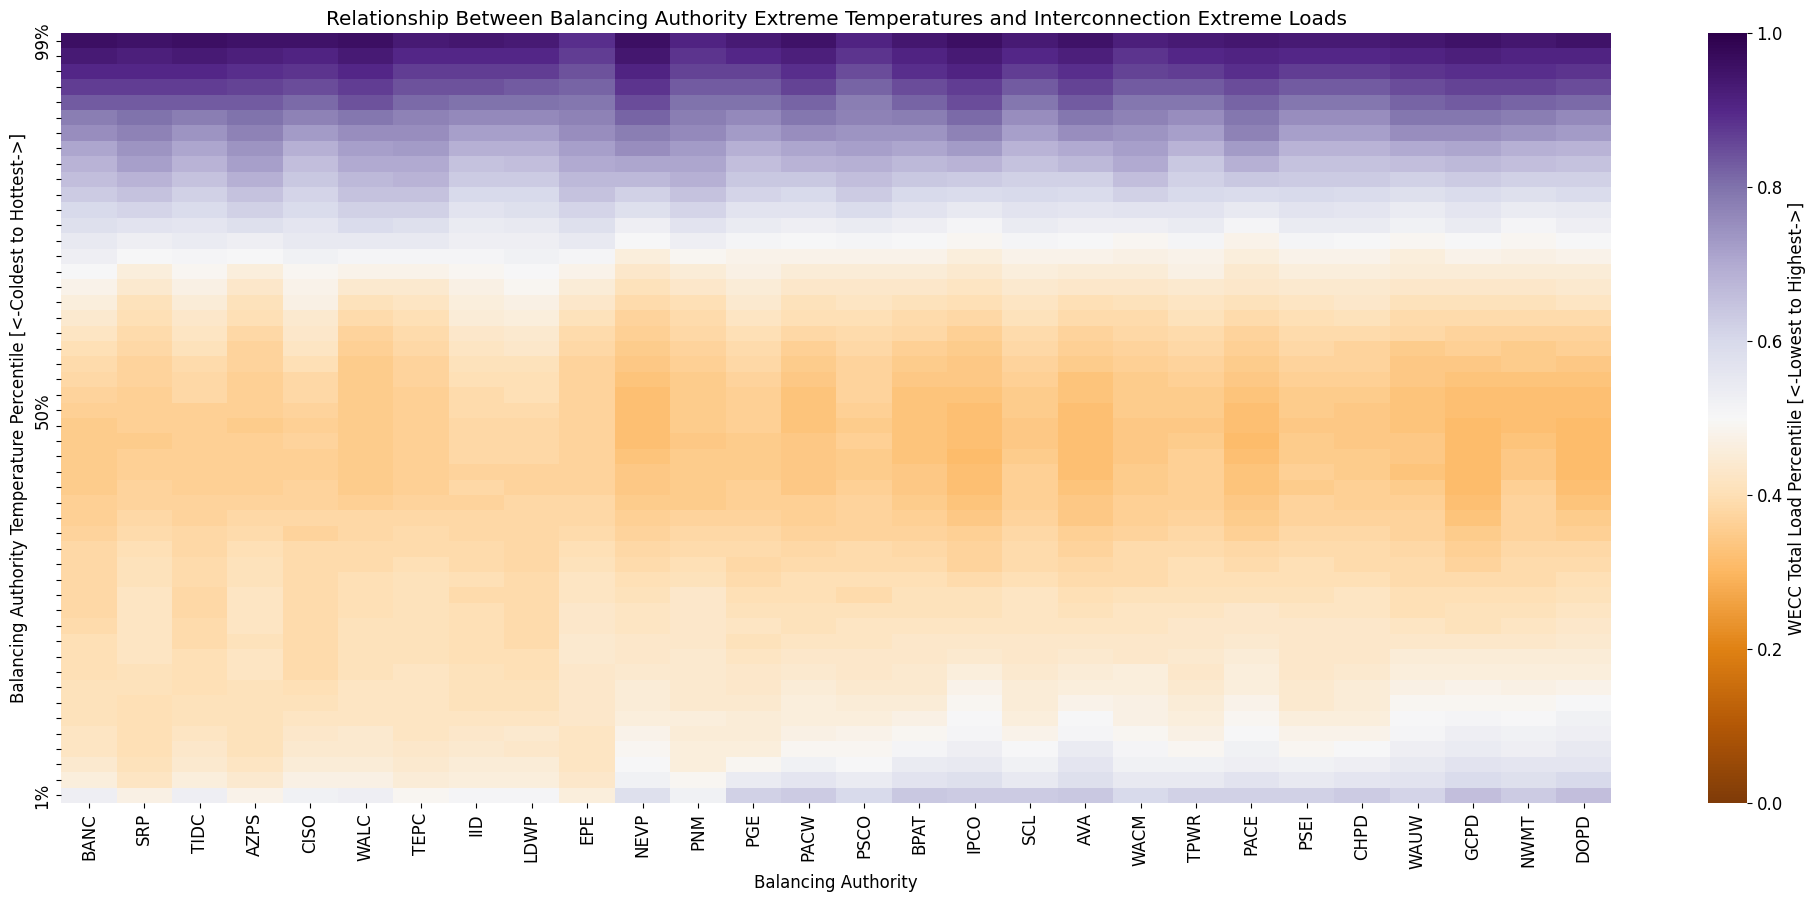

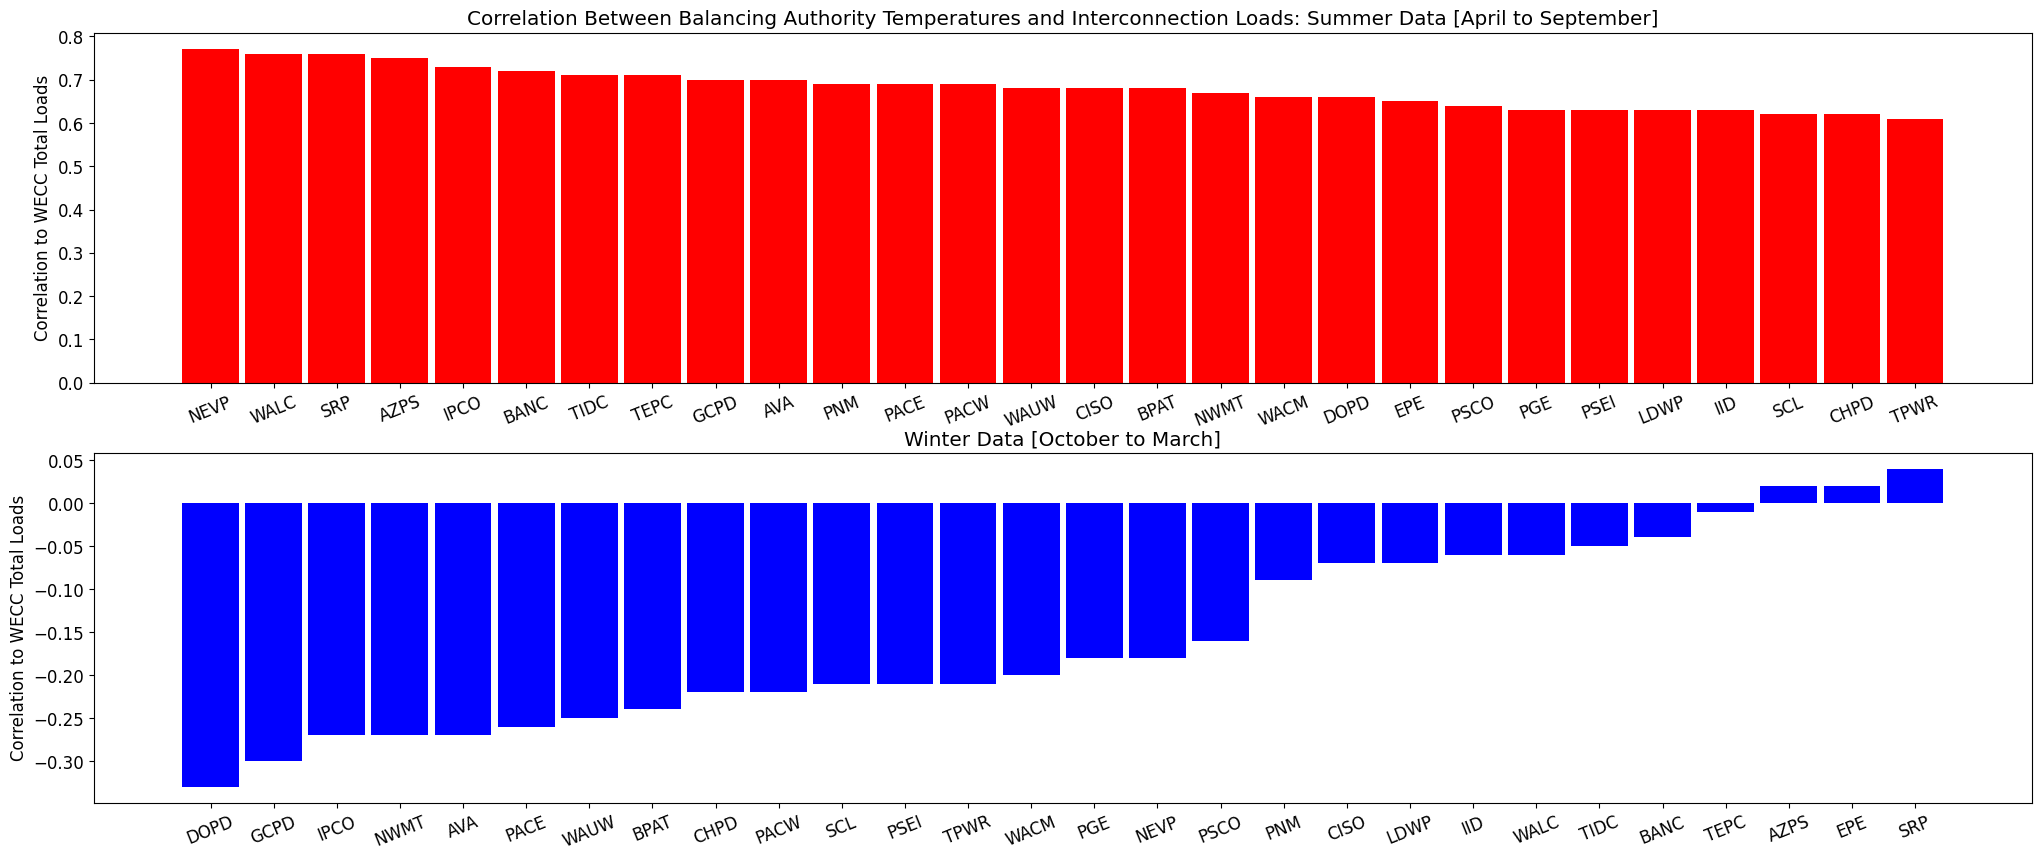

In [25]:
plot_ba_to_interconnection_relationships(interconnection = 'WECC',
                                         metadata_input_dir = metadata_input_dir,
                                         data_output_dir = data_output_dir,
                                         image_output_dir = image_output_dir, 
                                         image_resolution = 300, 
                                         save_images = True)
